In [1]:
! pip install natsort

In [2]:
import os
import sys
import numpy as np
from natsort import natsorted
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split

2024-06-24 01:10:12.047217: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-24 01:10:12.047315: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-24 01:10:12.171482: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
masked_image = [os.path.join('/drive/contenet/cv-dataset/mask/',file) for file in natsorted(os.listdir('/drive/contenet/cv-dataset/mask'))]
retina_image = [os.path.join('/drive/contenet/cv-dataset/retina/',file) for file in natsorted(os.listdir('/drive/contenet/cv-dataset/retina'))]

In [6]:
train_masked_image, test_masked_image = train_test_split(masked_image, test_size=0.2, random_state=42)
train_retina_image, test_retina_image = train_test_split(retina_image, test_size=0.2, random_state=42)

In [7]:

def preprocess_retina_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (256, 256))
    image = image / 255.0
    return image

def preprocess_mask_image(image_path):
    mask = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (256, 256))
    mask = mask / 255.0
    return np.expand_dims(mask, axis=-1)

def load_image(image_path, mask=False):
    if mask:
        return preprocess_mask_image(image_path)
    else:
        return preprocess_retina_image(image_path)

def load_data(retina_image_paths, mask_image_paths):
    retina_images = [load_image(img_path, mask=False) for img_path in retina_image_paths]
    mask_images = [load_image(img_path, mask=True) for img_path in mask_image_paths]
    return retina_images, mask_images

def generator(retina_image_paths, mask_image_paths, batch_size):
    while True:
        for i in range(0, len(mask_image_paths), batch_size):
            batch_retina_paths = retina_image_paths[i:i+batch_size]
            batch_mask_paths = mask_image_paths[i:i+batch_size]
            retina_images, mask_images = load_data(batch_retina_paths, batch_mask_paths)
            yield np.array(retina_images), np.array(mask_images)

In [8]:
import matplotlib.pyplot as plt

def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(20, 20))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        if image.shape[-1] == 1:  # If the image has a single channel (mask)
            plt.imshow(image.squeeze(), cmap='gray')
        else:
            plt.imshow(image)
    plt.show()


In [9]:
train_dataset = generator(train_retina_image, train_masked_image,32)
test_dataset = generator(test_retina_image, test_masked_image,32)

(32, 256, 256, 3) (32, 256, 256, 1)


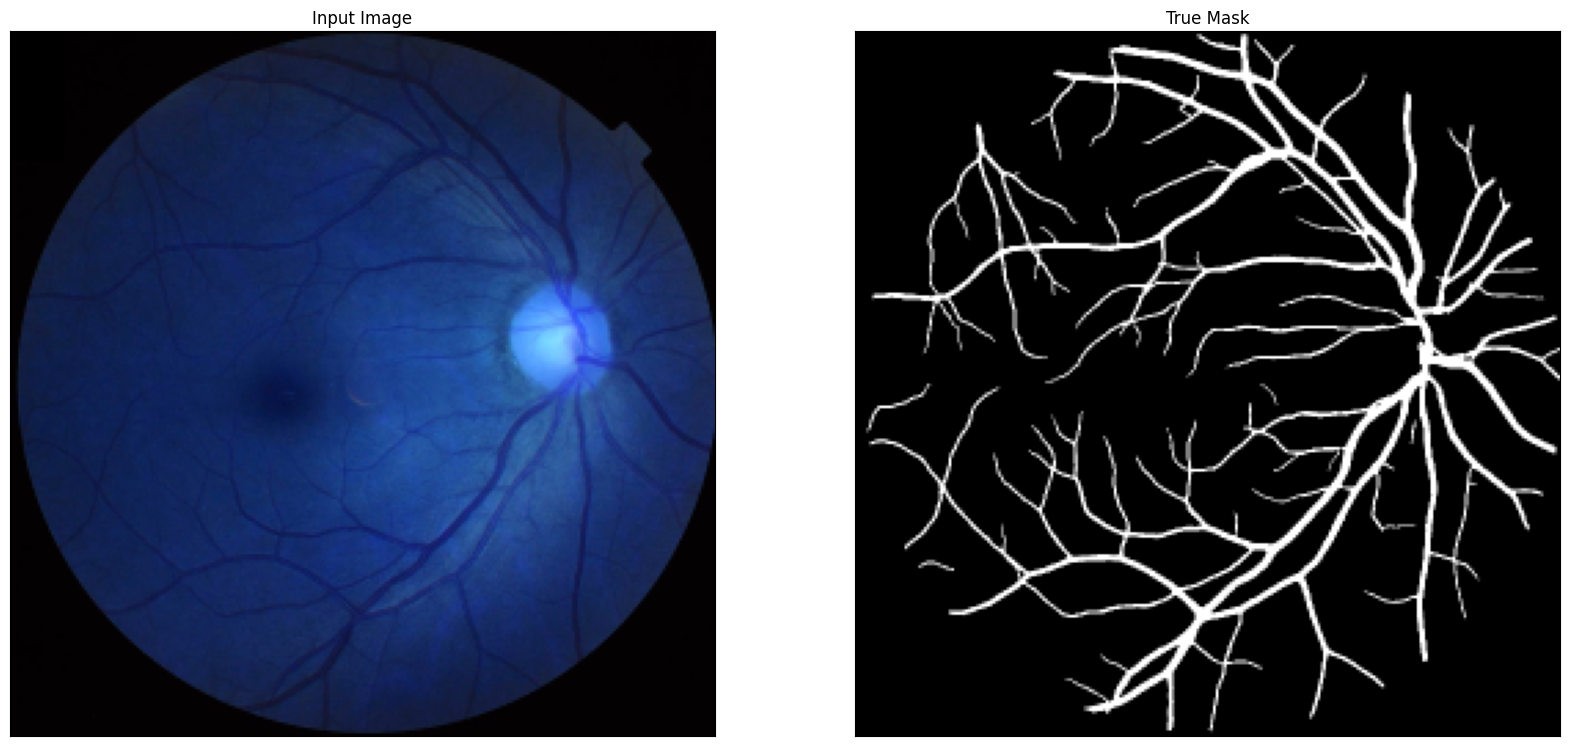

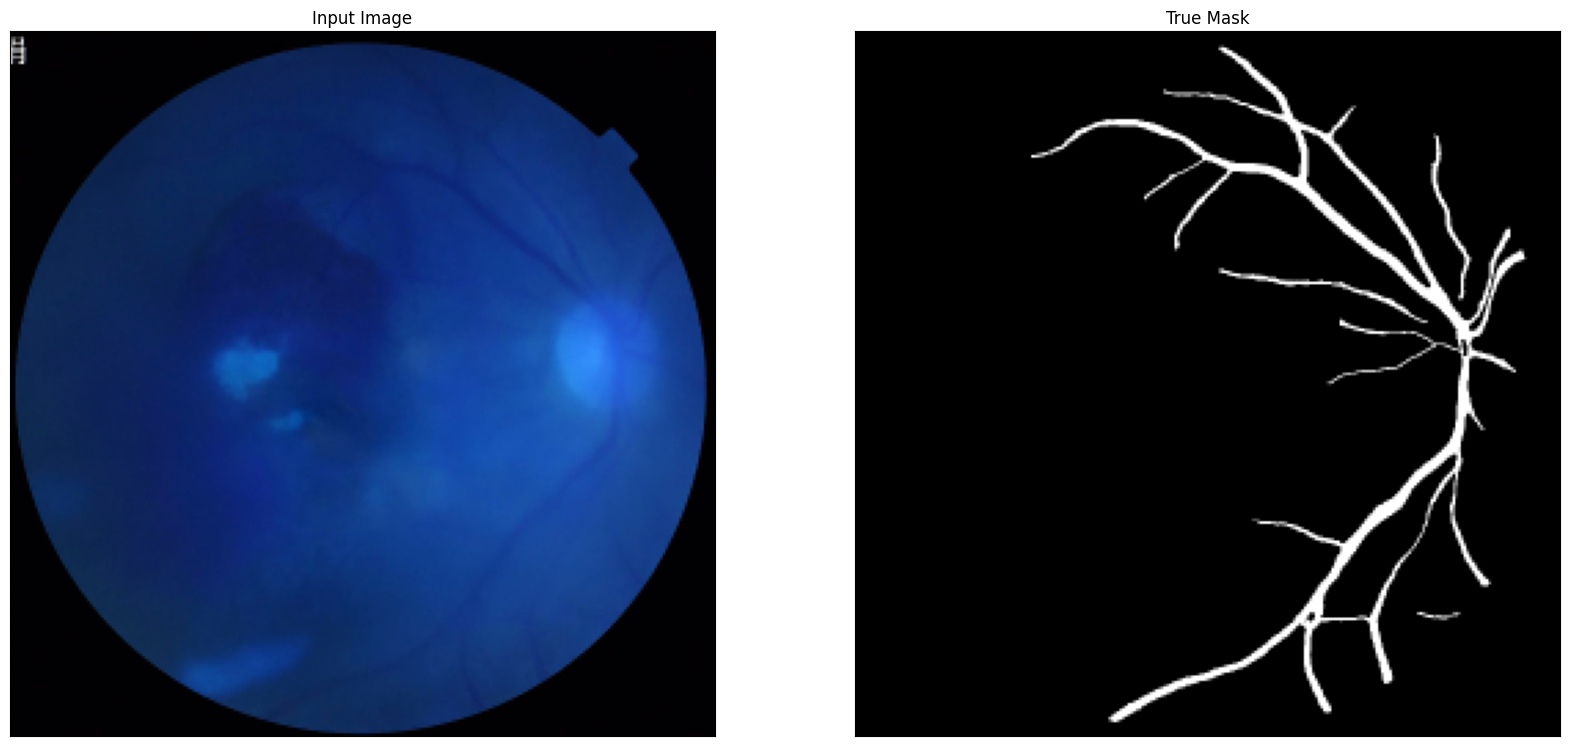

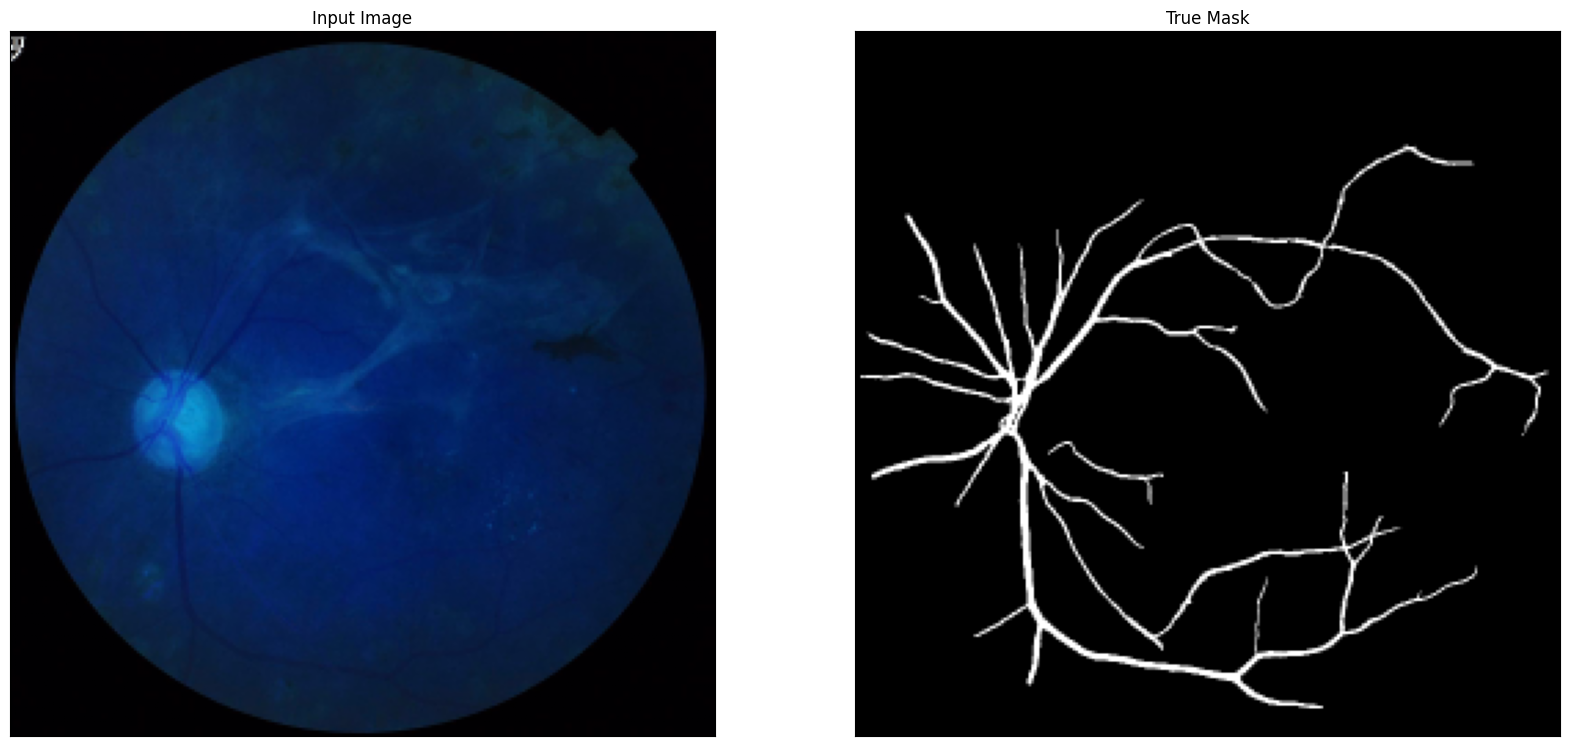

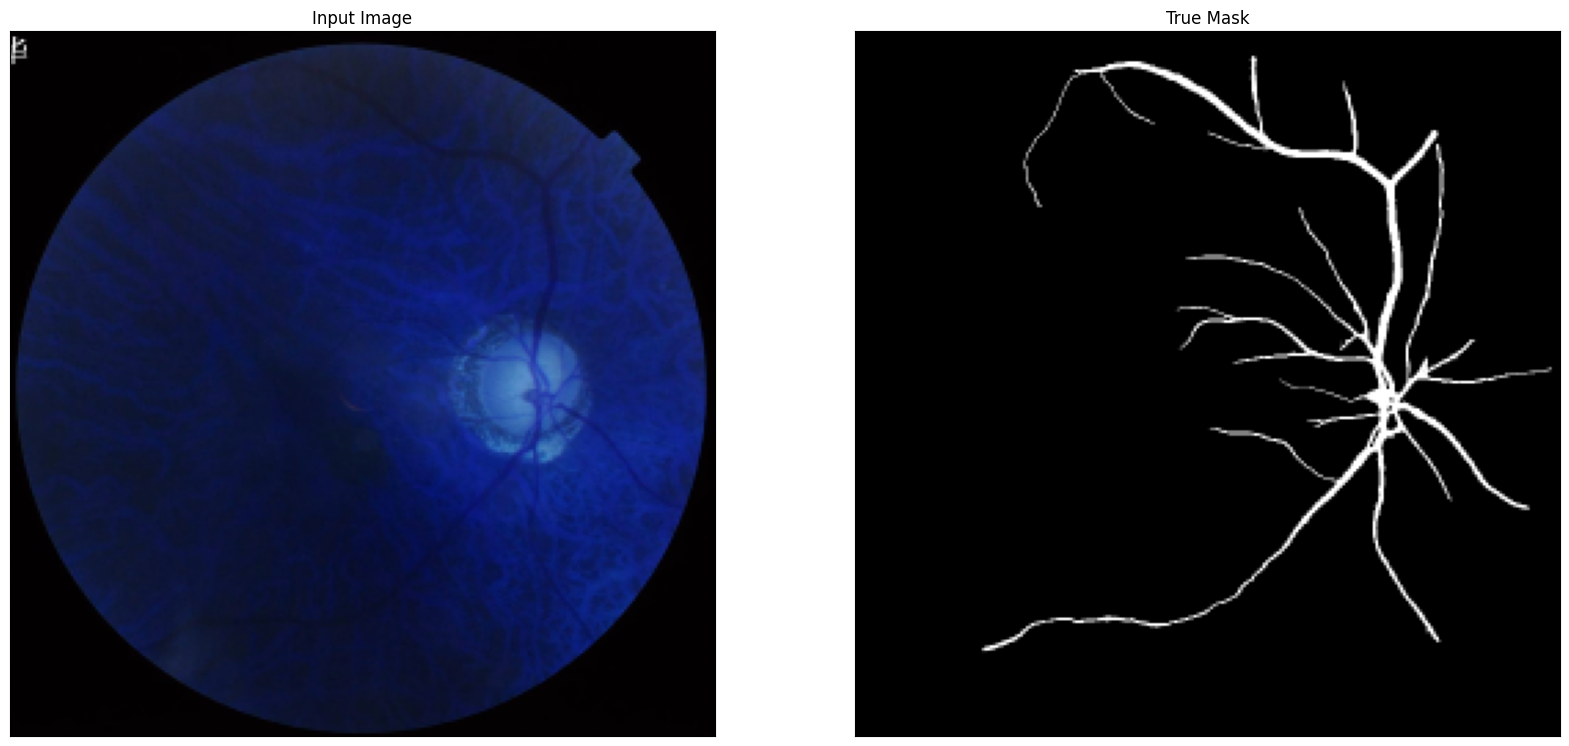

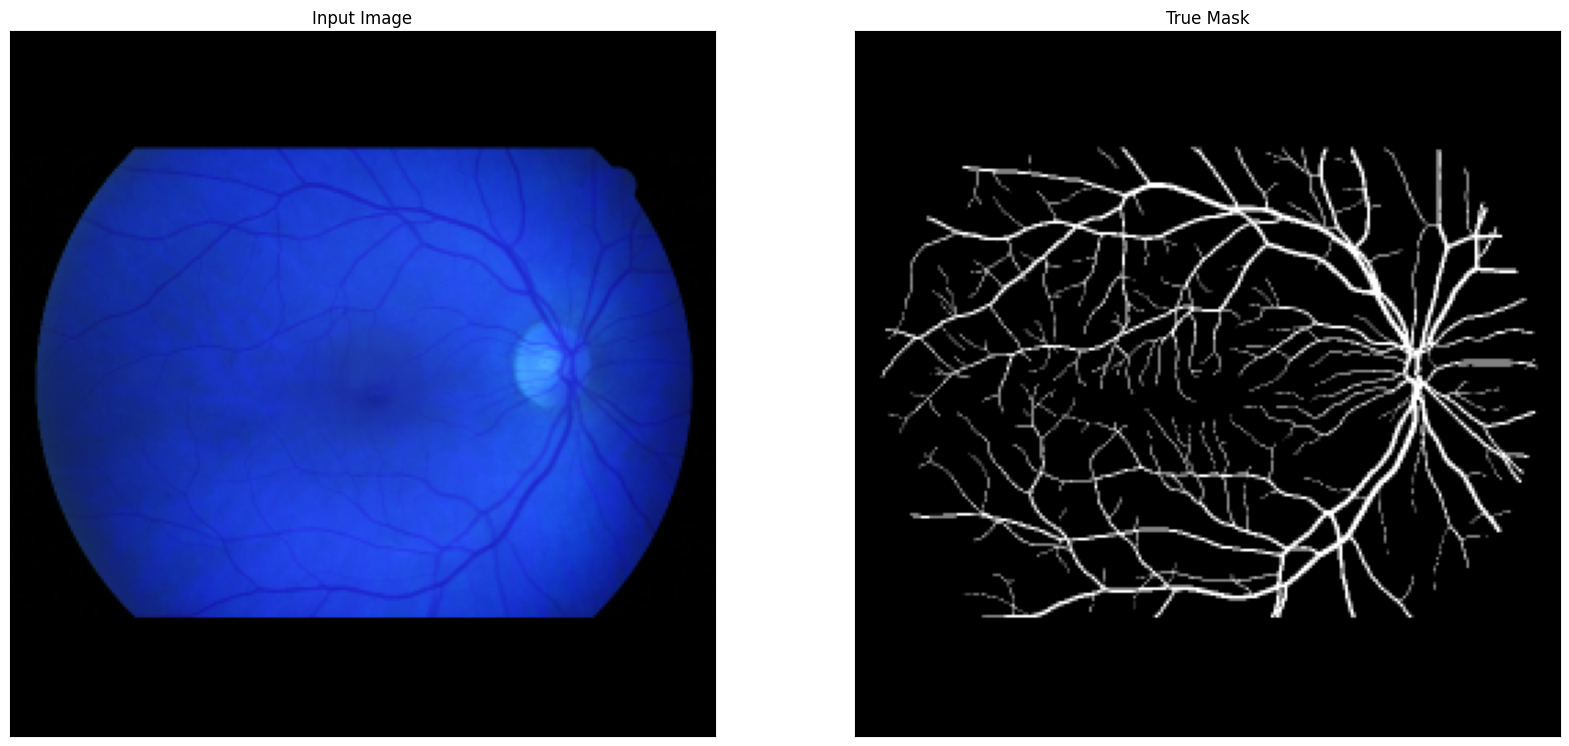

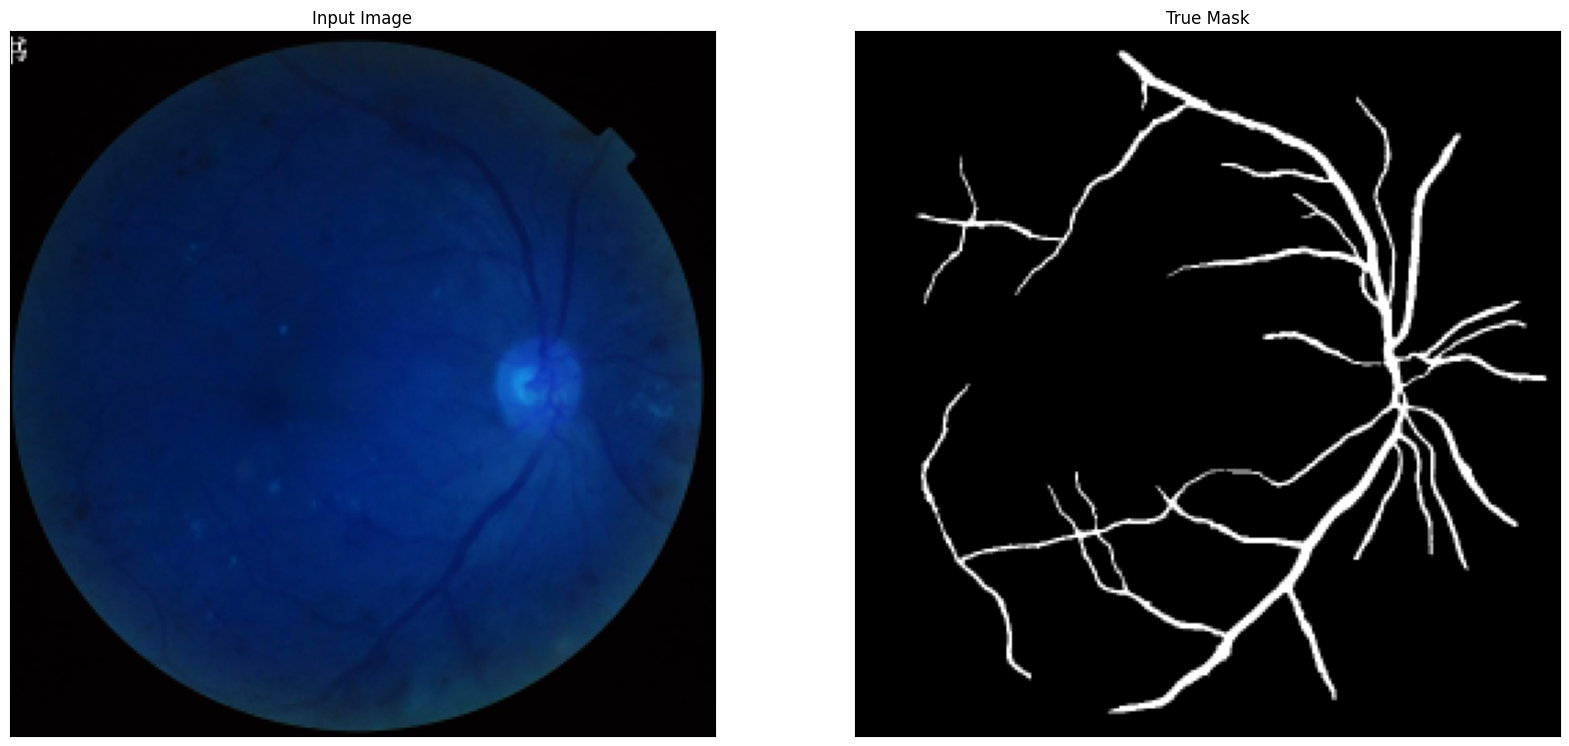

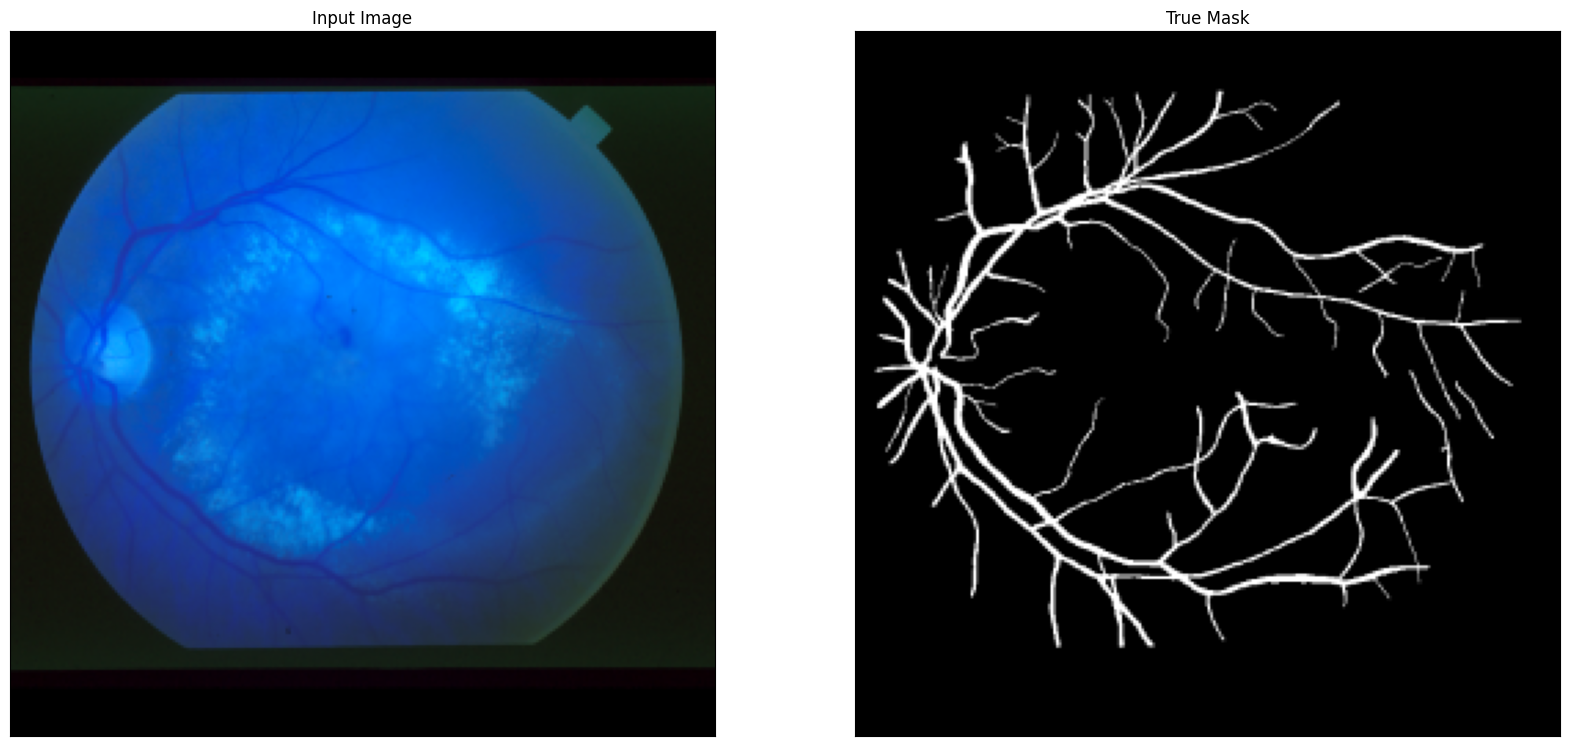

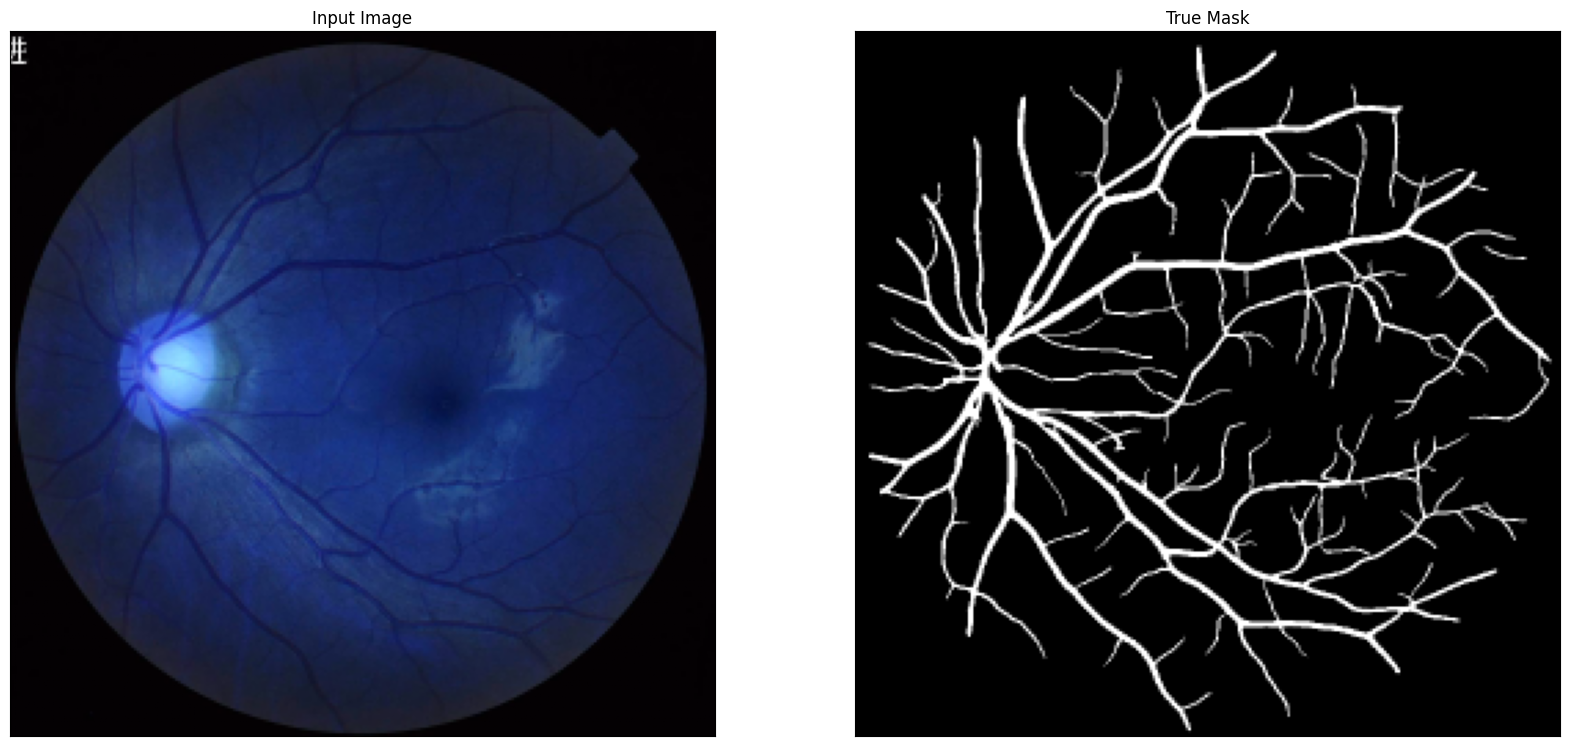

In [10]:
retina_images, mask_images = next(train_dataset)
print(retina_images.shape, mask_images.shape)

for i in range(10):
    visualize(Input_Image=retina_images[i], True_Mask=mask_images[i])


In [11]:
unet_model = tf.keras.models.load_model('/drive/contenet/models/unet_model.h5')

In [12]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


1/1 ━━━━━━━━━━━━━━━━━━━━ 98s 98s/step


I0000 00:00:1719191543.672945      96 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


              precision    recall  f1-score   support

  Background       0.97      1.00      0.98   1927037
      Object       0.95      0.67      0.78    170115

    accuracy                           0.97   2097152
   macro avg       0.96      0.83      0.88   2097152
weighted avg       0.97      0.97      0.97   2097152



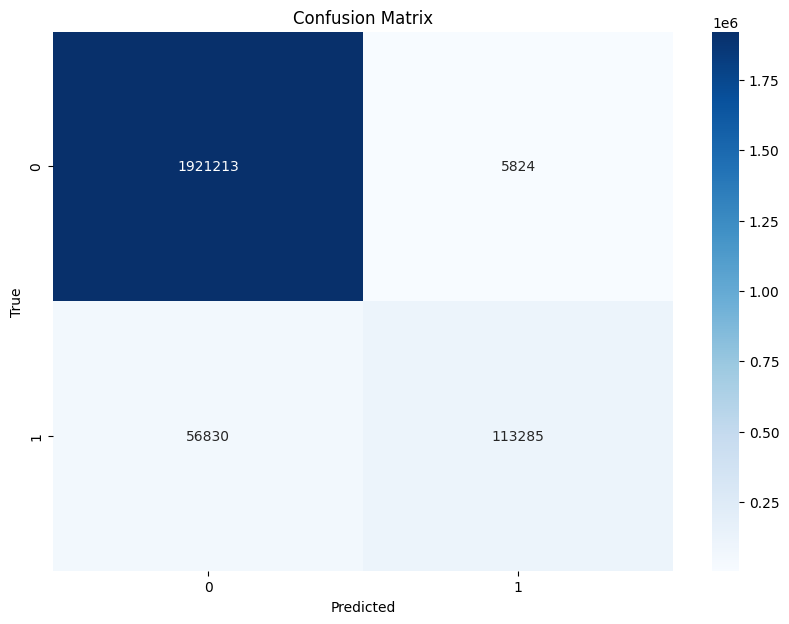

In [13]:
# Function to preprocess and flatten masks
def preprocess_and_flatten(mask, threshold=0.5):
    mask = (mask > threshold).astype(np.int32)
    return mask.flatten()

# Function to calculate classification report
def calculate_classification_report(true_masks, pred_masks):
    flattened_true = np.concatenate([preprocess_and_flatten(mask) for mask in true_masks])
    flattened_pred = np.concatenate([preprocess_and_flatten(mask) for mask in pred_masks])
    report = classification_report(flattened_true, flattened_pred, target_names=['Background', 'Object'])
    return report

# Function to plot confusion matrix
def plot_confusion_matrix(cm):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Example usage
retina_images, true_masks = next(test_dataset)  # Get a batch of test data
pred_masks = unet_model.predict(retina_images)  # Predict masks

# Calculate classification report for the batch
report = calculate_classification_report(true_masks, pred_masks)

# Print classification report
print(report)

# Calculate and plot confusion matrix for the batch
flattened_true = np.concatenate([preprocess_and_flatten(mask) for mask in true_masks])
flattened_pred = np.concatenate([preprocess_and_flatten(mask) for mask in pred_masks])
cm = confusion_matrix(flattened_true, flattened_pred)
plot_confusion_matrix(cm)


In [14]:
unet_model = tf.keras.models.load_model('/drive/contenet/models/sgnet_model.h5')

2024-06-24 01:14:16.147304: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng36{k2=1,k3=0} for conv (f32[32,64,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,256,256]{3,2,1,0}, f32[64,128,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-24 01:14:16.216415: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.069270265s
Trying algorithm eng36{k2=1,k3=0} for conv (f32[32,64,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,256,256]{3,2,1,0}, f32[64,128,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0

1/1 ━━━━━━━━━━━━━━━━━━━━ 113s 113s/step
              precision    recall  f1-score   support

  Background       0.98      0.99      0.99   1929163
      Object       0.92      0.82      0.87    167989

    accuracy                           0.98   2097152
   macro avg       0.95      0.91      0.93   2097152
weighted avg       0.98      0.98      0.98   2097152



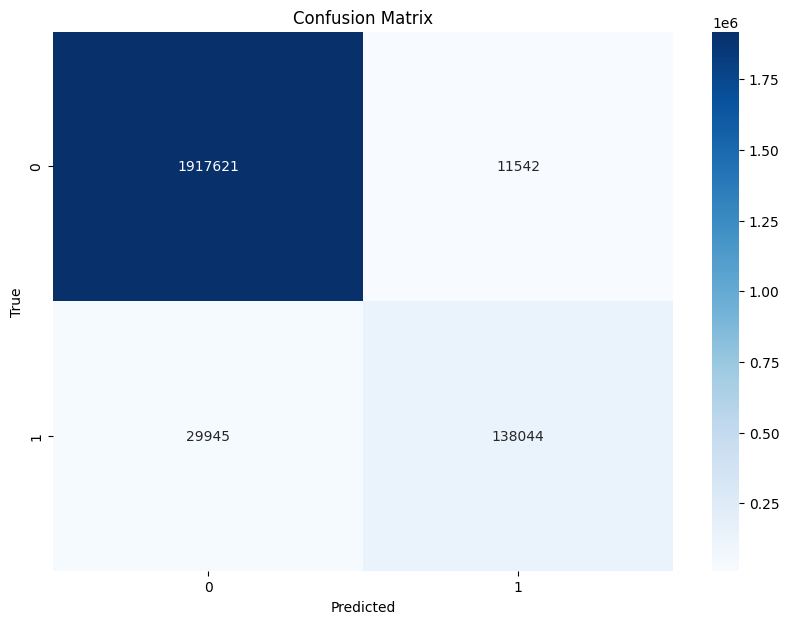

In [15]:
# Function to preprocess and flatten masks
def preprocess_and_flatten(mask, threshold=0.5):
    mask = (mask > threshold).astype(np.int32)
    return mask.flatten()

# Function to calculate classification report
def calculate_classification_report(true_masks, pred_masks):
    flattened_true = np.concatenate([preprocess_and_flatten(mask) for mask in true_masks])
    flattened_pred = np.concatenate([preprocess_and_flatten(mask) for mask in pred_masks])
    report = classification_report(flattened_true, flattened_pred, target_names=['Background', 'Object'])
    return report

# Function to plot confusion matrix
def plot_confusion_matrix(cm):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

retina_images, true_masks = next(test_dataset)  
pred_masks = unet_model.predict(retina_images)  

report = calculate_classification_report(true_masks, pred_masks)


print(report)

flattened_true = np.concatenate([preprocess_and_flatten(mask) for mask in true_masks])
flattened_pred = np.concatenate([preprocess_and_flatten(mask) for mask in pred_masks])
cm = confusion_matrix(flattened_true, flattened_pred)
plot_confusion_matrix(cm)
